<a href="https://colab.research.google.com/github/marcelovmaciel/cifar-nocnn/blob/master/Exercicio_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo:

1. Importar bibliotecas basicas e dataset CIFAR10
2. Aplicar SURF/SIFT em todas as imagens, salvando os descriptors das features das imagens
3. Agrupar (cluster) descriptors semelhantes (para que eles podem ser identificados como um mesmo descriptor). As médias de descriptors semelhantes são usados como base de um dicionário de features.
4. Mapear os descriptors de cada imagem para os descriptors do dicionário (Dessa forma, as imagens são transformadas em um vetor, onde cada valor é o número de ocorrências dos descriptors base do dicionário)
5. Finalmente, treinar um classificador usando os vetores de descriptors como entrada (tendo em mente que um RF aplicado nas imagens sem pre-processamento tem acurácia de 48%).

Nesses links, é mostrado o que está sendo almejado com esse código.

https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb

https://www.mathworks.com/help/vision/examples/image-category-classification-using-bag-of-features.html

A ideia é criar um dicionário de features, um espaço vetorial, no qual as imagens possam ser analisadas em busca das caracteristicas que separam uma classe de outra.

A técnica se chama "Bag of features", em analogia ao equivalente para textos "Bag of Words". Ou também "Bag of Visual Words" (BOVW).

# 1. Bibliotecas e Base de dados CIFAR10

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# https://keras.io/datasets/

from keras.datasets import cifar10

(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# 50000 imagens de treino de 32x32 em RGB
# Base de testes tem 10000
images_train.shape 

(50000, 32, 32, 3)

In [4]:
# 50000 labels dos dados de treino
labels_train.shape 

(50000, 1)

**OpenCV com pacotes patentiados**

In [5]:
# SIFT faz parte de um modulo especial do OpenCV.
# Precisa instalar como se fosse outra biblioteca e as versões devem ser compatíveis.
# https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

import cv2

    100% |████████████████████████████████| 25.0MB 1.4MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
    100% |████████████████████████████████| 30.6MB 1.5MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


# 2. SIFT feature extraction

In [0]:
# Links:
# https://stackoverflow.com/questions/29133085/what-are-keypoints-in-image-processing
# https://docs.opencv.org/3.4.0/df/dd2/tutorial_py_surf_intro.html
# https://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/

# Are the keypoint objects useful at all for image classification?
# kp, des = surf.detectAndCompute(img,None)

# Tried to solve the problem with list comprehension.
# Images have different number of features. Have to make results have same size.
# Could not get it to work. Maybe it was because of the NoneType error, idk.

# sift = cv2.xfeatures2d.SIFT_create(30)
# features = [sift.detectAndCompute(image, None)[1] for image in x_train]
# for i in range(50000):
#     features2[i][0:np.size(features[i])] += np.flatten(features[i])

# Theoretically, SURF is better than SIFT (they are both functions for extracting features),
# but SURF is giving me almost zero features when applied to the images, while
# SIFT gives an average of around 13

In [0]:
# Old code. Ignore this.

# Code for extracting descriptors and, since the number of features per image is different,
# pad the descriptor vector of the images with zeros to make them have the same size
# and create a matrix of same sized vectors to use as input for the classifier

# features = np.zeros((50000, 4500))
# totalfeatures = 0
# for i in range(50000):
#     sift = cv2.xfeatures2d.SIFT_create(500)
#     # gray = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)
#     des = sift.detectAndCompute(x_train[i], None)[1]
#     if des is not None: # Some images have no features and return a NoneType
#         totalfeatures += len(des)
#         des = des.flatten()
#         features[i][0:len(des)] = des
        
# features2 = np.zeros((10000, 4500))
# for i in range(10000):
#     sift = cv2.xfeatures2d.SIFT_create(500)
#     # gray = cv2.cvtColor(x_test[i], cv2.COLOR_BGR2GRAY)
#     des = sift.detectAndCompute(x_test[i], None)[1]
#     if des is not None: # Some images have no features and return a NoneType
#         des = des.flatten()
#         features2[i][0:len(des)] = des        

In [0]:
# Extracting descriptors from the images and creating a list of descriptor vectors

# Descriptors of the Images
# Remember some images dont have any descriptors.
# These will have a None at its position in the descriptor list
maxfeaturesperimage = 500

sift = cv2.xfeatures2d.SIFT_create( maxfeaturesperimage )
descriptors_train = [sift.detectAndCompute(image, None)[1] for image in images_train]
descriptors_test  = [sift.detectAndCompute(image, None)[1] for image in images_test]

# 3. Dicionário de features

In [0]:
indexesNotNone = [(item is not None) for item in descriptors_train] # list of bool for not-NoneType entries

In [0]:
indexesNotNone = np.array(indexesNotNone).nonzero()[0] # converting to list of integer indexes. (nonzero() returns a tuple)

In [0]:
descriptors_train = np.array(descriptors_train) # Lists do not accept list of indexes. Must convert to np.array

In [0]:
descriptor_list = np.concatenate(descriptors_train[indexesNotNone])

In [0]:
from sklearn.cluster import KMeans

In [0]:
feature_dict = KMeans(n_clusters= 500, verbose= True, max_iter= 40, n_jobs= -1)
feature_dict.fit(descriptor_list)

# 4. Mapeamento dos descriptors usando o dicionário

In [0]:
features_train = []

In [0]:
features_train = []
for image in images:
      image = gray(image)
      keypoint, descriptor = features(image, extractor)
      if (descriptor is not None):
          histogram = build_histogram(descriptor, kmeans)
          preprocessed_image.append(histogram)

In [0]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

# Rascunho

In [0]:


np.fft2(x_train[0])

In [0]:

img = Image.open('image.png').convert('LA')
img.save('greyscale.png')

In [0]:
img = Image.fromarray(x_train[7])

In [0]:
img = img.convert('LA')

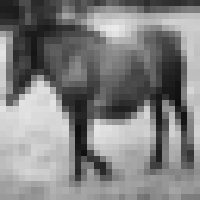

In [0]:
img.resize((200,200))

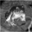

In [27]:
Image.fromarray(gray)

numpy.ndarray

In [59]:
np.concatenate(x_train[0].reshape(1, -1), features[0][1])

TypeError: ignored

([<KeyPoint 0x7fe291f8b600>,
  <KeyPoint 0x7fe291f8b630>,
  <KeyPoint 0x7fe291f8b660>,
  <KeyPoint 0x7fe291f8b690>,
  <KeyPoint 0x7fe291f8b840>,
  <KeyPoint 0x7fe291f8b7b0>,
  <KeyPoint 0x7fe291f8b960>,
  <KeyPoint 0x7fe291f8b990>,
  <KeyPoint 0x7fe291f8b9c0>,
  <KeyPoint 0x7fe291f8b9f0>,
  <KeyPoint 0x7fe291f8ba20>,
  <KeyPoint 0x7fe291f8ba50>,
  <KeyPoint 0x7fe291f8ba80>,
  <KeyPoint 0x7fe291f8bab0>,
  <KeyPoint 0x7fe291f8bae0>,
  <KeyPoint 0x7fe291f8bb10>,
  <KeyPoint 0x7fe291f8bb40>,
  <KeyPoint 0x7fe291f8bb70>],
 array([[ 30., 101.,  14., ...,   0.,   0.,  45.],
        [  0.,   0.,   0., ...,  52.,  17.,   7.],
        [  2.,   5.,   9., ...,  32.,  17.,  36.],
        ...,
        [  0.,   0.,   0., ...,  34.,   4.,   9.],
        [ 72.,  36.,  10., ...,   4.,   1.,   0.],
        [  2.,   0.,   0., ...,   1.,  47., 153.]], dtype=float32))

In [0]:
x = np.arange(10)

In [154]:
type(descriptors_train)

list

In [0]:
ind = np.array([0,1,2,3])